Gradient Boosting Machines ( GBM )
temeli adaptive boostinge dayanır
AdaBoost'un temel amacıda, yanlış sınıflandırılan örnekleri daha fazla ağırlık vererek modelin başarısını artırmaktır
---
![alt text](pngs/9.png)
mesela burada + lar bir sınıfı - ler başka bir sınıfı temsil ediyor mavinin içindeki + lar doğru kırmızının içindeki - ler doğru sınıftalar

adaboost kutulara bakıyor ve doğru sınıfların doğru bölgede olmasına dikkat ediyor daha sonra  en iyi oranları birleştiriyor
öğrenici model yanlış sınıfın ağırlığını arttırıyor ve sonraki modele işi devrediyor
sonraki modelin hata fonksiyonu bu sefer bu hatalı sınıfları daha çok dikkate alıyor

Gradient Boosting Machines = gradient descent + boostindir yani ağaç optimizasyonudur nasıl yaptığını basit adımlarla görelim
---
![alt text](pngs/10.png)
grafik_1 düşünüldüğünde y sabit değerini manipüle etmek için ne yapmalıyız sorusuna grafik_2 x ekleyerek cevap vermiş
sonra grafik_3 dahada manipülasyonu arttırmak için sin(x) eklemiş bu additive model gradient boostingin temelidir
yapılan her düzeltme hata fonksinunu (mesela mse) azaltmak amacıyla yapılmıştır
gradient boosting işte bunun gibi her seferinde önceki modelin hatlarını adım adım düzeltmeye çalışır ve tahmin edilen değerin gerçeğe en yakın olmasını hedefler
---
![alt text](pngs/11.png)
buradaki deltalar artık değerler ve f0 ilk modelimiz
yani modele artıklarla ekle çıkar yapa yapa hatayı minimize ediyoruz
### formüllü hali --> y = f0 + delta_1 + delta_2 + ... delta_n
---


![alt text](pngs/12.png)

##### yine klasik tahmin tablosu üzerinden
rent in ortalaması 1418 = f0 = y_predict grafikte sabit değer olarak gösteriliyor
y-f0 ile modelin hata skorunu görüyoruz ve grafikte noktalarla doğrumuza uzaklığını gösteriyoruz
işte amacımız bu sabit değeri eğip bükerek gerçek değerlere adım adım yaklaştırmak


![alt text](pngs/13.png)

modele soktuk tahmini = f0 ı gördük 
hatalarımızı y-f0 ile gördük şimdi ikinci modellemeye atlıyoruz y-f0 ile metrekareyi modelliyoruz
min hata oranı nerede olabileceğine göre böldük ki burada son satır orayı ağaç dalına ayırdık
sonra y-f0 tahmini(ortalaması) --> delta_1
şimdide ilk tahminimizle delta_1 i çıkartarak yeni f1 değerimizi buluyoruz
bu şekilde ilerleyerek optimizasyon gerçekleşir

aşağıdaki grafiklerde her adımda nasıl bir değişim gözlendiği


In [96]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_validate, RandomizedSearchCV, validation_curve

pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)

warnings.simplefilter(action='ignore', category=Warning)

df = pd.read_csv("datasets/diabetes.csv")

y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [97]:
################################################
# GBM
################################################

gbm_model = GradientBoostingClassifier(random_state=17)

gbm_model.get_params()
# learning rate parametresi artıkların güncellenme hızı
# learning rate in küçük olması ile model daha küçük adımlar atarak daha yavaş ama dikkatli öğrenmeyi sağlar
# n_estimators random forest ta bağımsız ağaç sayısı iken burada optimizasyon sayısıdır
# iyi bir model küçük learning rate yüksek n_estimators ister ama eğitim süreside uzar

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'log_loss',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 17,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [98]:
cv_results = cross_validate(gbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
# 0.7591715474068416
cv_results['test_f1'].mean()
# 0.634
cv_results['test_roc_auc'].mean()
# 0.82548

gbm_params = {"learning_rate": [0.01, 0.1],
              "max_depth": [3, 8, 10],
              "n_estimators": [500, 1000],
              "subsample": [1, 0.7]} # overfittingin önüne geçiyor verinin yüzde kaçına bakayım diye soruyor

gbm_best_grid = GridSearchCV(gbm_model, gbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

gbm_best_grid.best_params_

Fitting 5 folds for each of 24 candidates, totalling 120 fits


{'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.7}

In [99]:
gbm_final = gbm_model.set_params(**gbm_best_grid.best_params_, random_state=17, ).fit(X, y)


cv_results = cross_validate(gbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

np.float64(0.8349035639412998)

# XGBoost ( eXtreme Gradient Boosting )

gbm in daha hızlı ve optimize versiyonudur

In [100]:
################################################
# XGBoost
################################################
from xgboost import XGBClassifier

xgboost_model = XGBClassifier(random_state=17)
xgboost_model.get_params()
cv_results = cross_validate(xgboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean()
# 0.75265
cv_results['test_f1'].mean()
# 0.631
cv_results['test_roc_auc'].mean()
# 0.7987

np.float64(0.7934919636617749)

In [101]:
xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8],
                  "n_estimators": [100, 500, 1000],
                  "colsample_bytree": [0.7, 1]} # yeni parametremiz subsample a benziyor subsample gözlemleri kısıtlıyordu
# colsample_bytree de özellikleri kısıtlıyor yani daha az sütun ismine bakıyor gibi düşünülebilir
# (ama feature_importance fonksiyonu ile karıştırma)  böylece yine overfitting önüne geçilir

xgboost_best_grid = GridSearchCV(xgboost_model, xgboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

xgboost_final = xgboost_model.set_params(**xgboost_best_grid.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(xgboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])
cv_results['test_accuracy'].mean() # 0.7591
cv_results['test_f1'].mean() # 0.6353
cv_results['test_roc_auc'].mean() # 0.8204
# çokta fazla birşey artmadı ama olsun


Fitting 5 folds for each of 24 candidates, totalling 120 fits


np.float64(0.8204004192872117)

---

# LightGBM
buda xgboost eğitim süresi ve performansını dahada optimize ediyor
bu hızlıdır tercih edilmelidir

In [102]:
################################################
# LightGBM
################################################
from lightgbm import LGBMClassifier


lgbm_model = LGBMClassifier(random_state=17)
lgbm_model.get_params()

cv_results = cross_validate(lgbm_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

accuracy_mean = cv_results['test_accuracy'].mean()
f1_mean = cv_results['test_f1'].mean()
roc_auc_mean = cv_results['test_roc_auc'].mean()

print(f"Test Accuracy (Ortalama): {accuracy_mean:.4f}")
print(f"Test F1 Score (Ortalama): {f1_mean:.4f}")
print(f"Test ROC AUC (Ortalama): {roc_auc_mean:.4f}")

[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000066 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 667
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [103]:
lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [100, 300], # lightgbm in en önemli parametresi budur buna özellikle odaklan
               "colsample_bytree": [0.5, 1]}

lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y)

v_results = cross_validate(lgbm_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[LightGBM] [Info] Number of positive: 215, number of negative: 400
[LightGBM] [Info] Number of positive: 215, number of negative: 400
[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Number of positive: 215, number of negative: 400
[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Number of positive: 215, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.206450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 670
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.193459 seconds.
You can set `force_col_wise=tru

np.float64(0.7990293501048218)

---
# CatBoost
buda kategorik değişkenlerle otomatikmen mücadele edebilen bir gbm türevi

In [104]:
################################################
# CatBoost
################################################
# from catboost import CatBoostClassifier

# catboost_model = CatBoostClassifier(random_state=17, verbose=False)

# cv_results = cross_validate(catboost_model, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

# cv_results['test_accuracy'].mean()
# cv_results['test_f1'].mean()
# cv_results['test_roc_auc'].mean()


# catboost_params = {"iterations": [200, 500],
#                    "learning_rate": [0.01, 0.1],
#                    "depth": [3, 6]}


# catboost_best_grid = GridSearchCV(catboost_model, catboost_params, cv=5, n_jobs=-1, verbose=True).fit(X, y)

# catboost_final = catboost_model.set_params(**catboost_best_grid.best_params_, random_state=17).fit(X, y)

# cv_results = cross_validate(catboost_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

# cv_results['test_accuracy'].mean()
# cv_results['test_f1'].mean()
# cv_results['test_roc_auc'].mean()

In [105]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

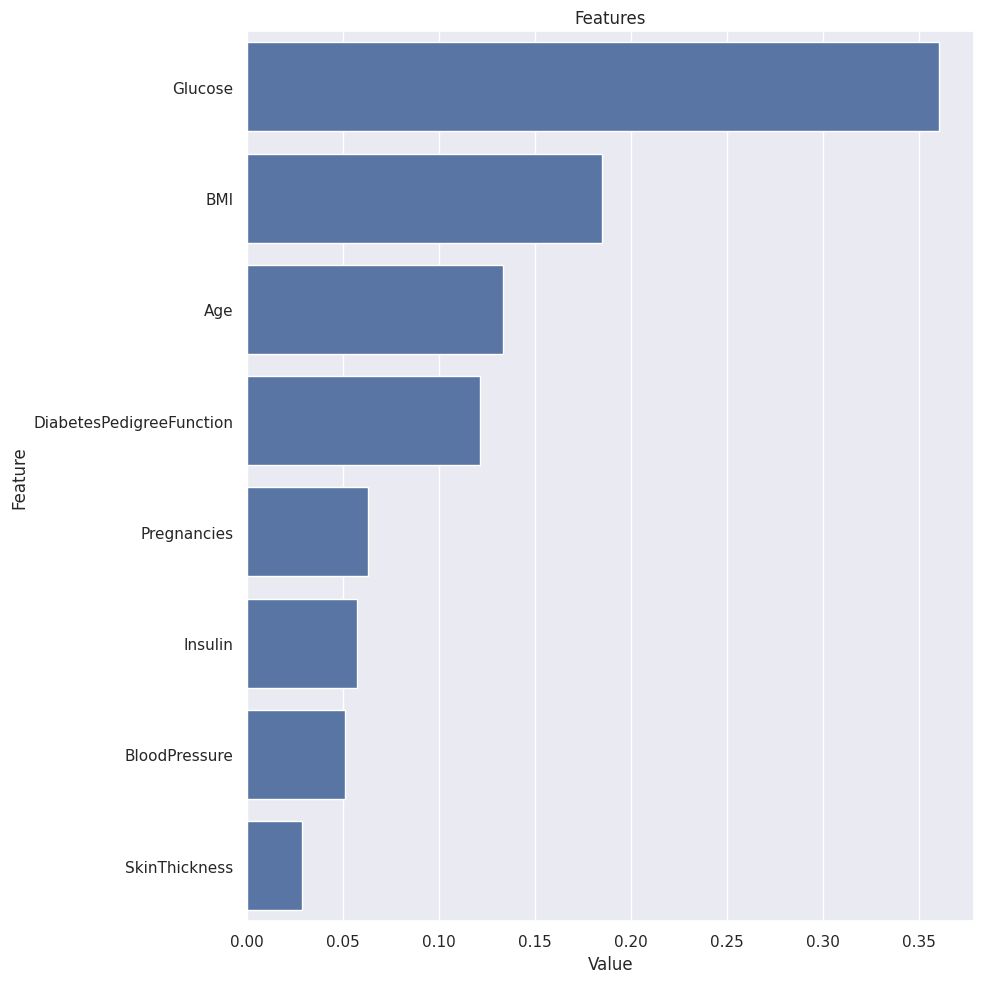

In [106]:
plot_importance(gbm_final, X)

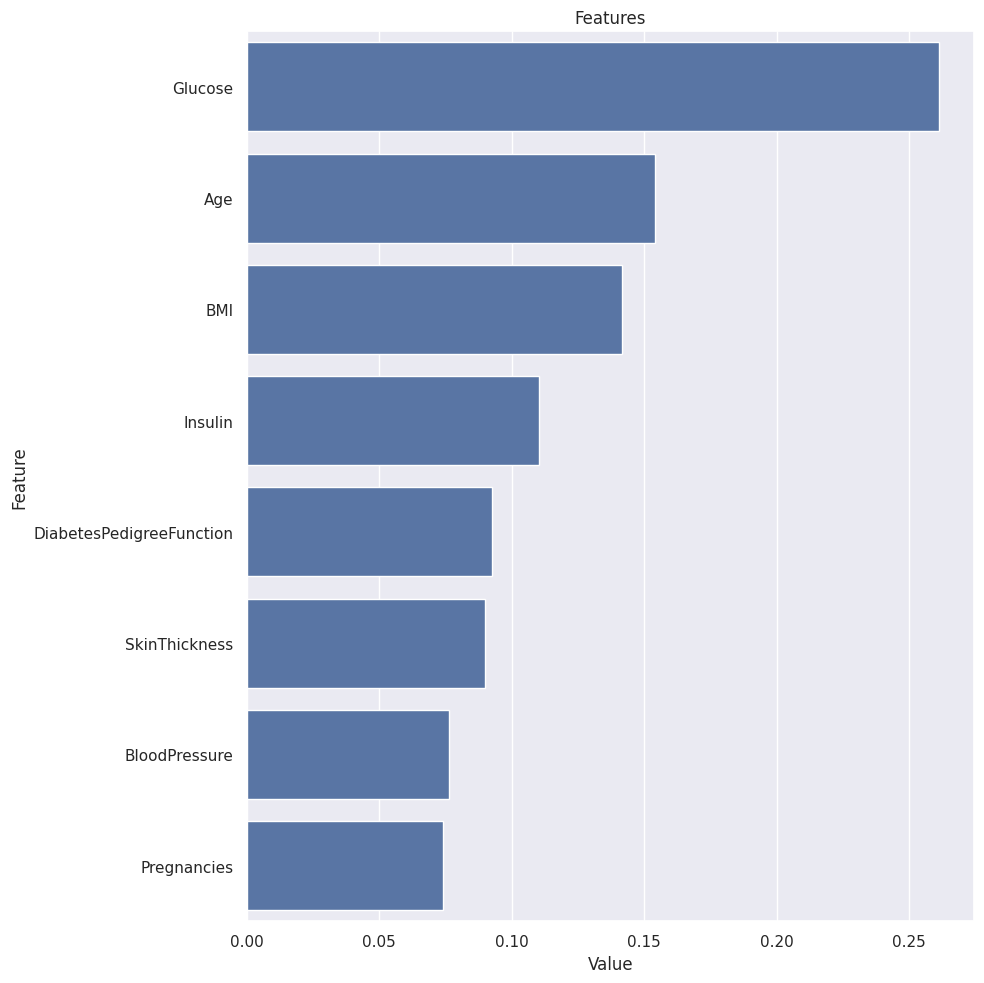

In [109]:
plot_importance(xgboost_final, X)
#plot_importance(catboost_final, X)

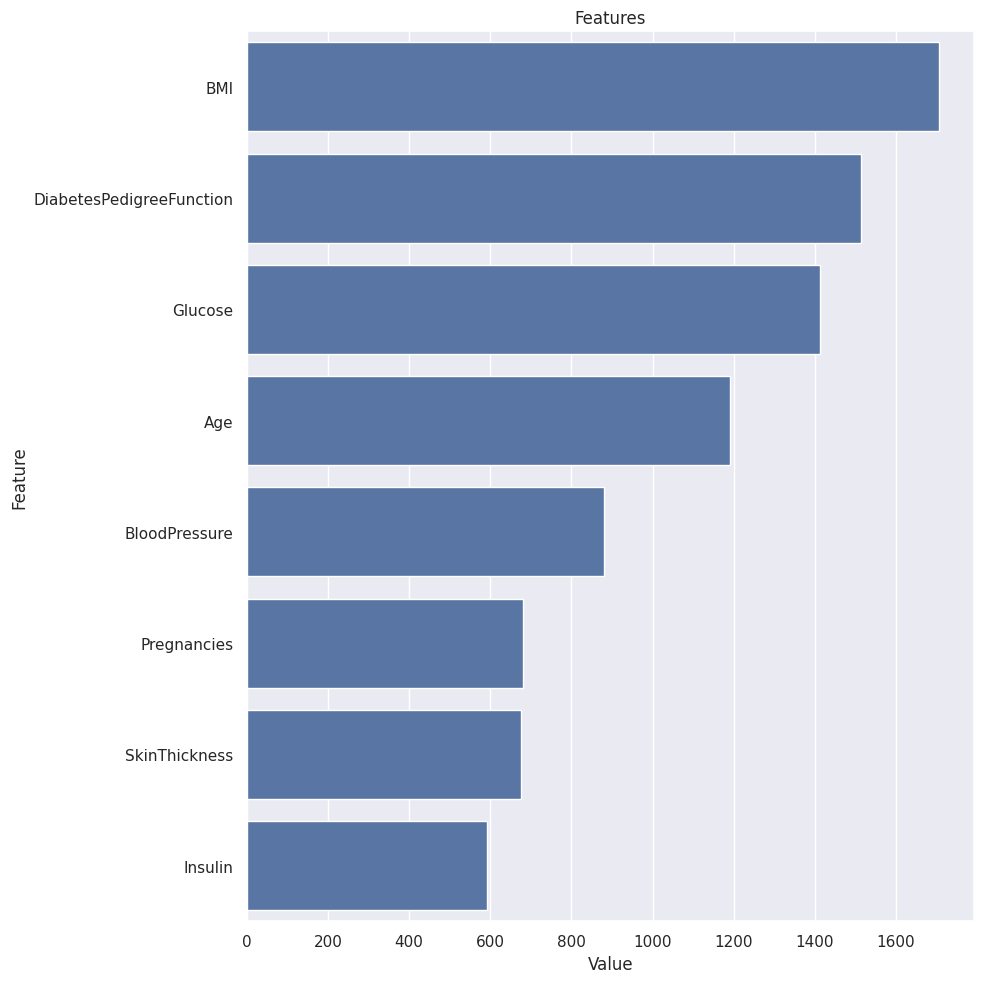

In [108]:
plot_importance(lgbm_final, X) # mesela lightgbm de ilk 3 parametre değişti


## yani anlatmak istediğim her modelin önem verdiği parametreler ayrı

---

In [111]:
# daha öncesinde gridsearchcv yöntemiyle en iyi parametreyi tek tek modelde deneyerek en iyi kombinasyonu buluyorduk
# random search cv de ise parametreleri rastgele arar
# 1. GridSearchCV:

# Ne Yapar: Bu yöntem, belirttiğiniz tüm parametrelerin her bir kombinasyonunu deneyerek en iyi hiperparametre kombinasyonunu bulmaya çalışır.
#           Bu, geniş bir arama alanınız olduğunda zaman alıcı olabilir.
# Avantajı: Tüm parametre kombinasyonlarını denediği için kesin sonuçlar elde edilir.
# Dezavantajı: Çok zaman alıcı olabilir, özellikle büyük veri setlerinde ve geniş parametre aralıklarında.

# 2. RandomSearchCV:

# Ne Yapar: GridSearchCV'nin aksine, rastgele parametre kombinasyonları seçerek en iyi hiperparametreleri arar.
#           Bu, geniş parametre aralıklarında daha hızlı sonuçlar elde etmenizi sağlar.
# Avantajı: Daha kısa sürede sonuç alırsınız çünkü tüm kombinasyonları denemek yerine rastgele seçer.
# Dezavantajı: En iyi parametreyi bulma şansı, grid search'e göre daha düşüktür çünkü tüm kombinasyonlar denenmez.

# İlk olarak RandomSearchCV kullanarak daha geniş bir parametre yelpazesinde arama yapabilirsiniz. 
# Bu, zaman tasarrufu sağlar çünkü parametrelerin tüm kombinasyonlarını denemek yerine, rastgele kombinasyonlar denenir.
# Sonra, elde ettiğiniz en iyi sonucu daraltarak GridSearchCV ile daha hassas bir arama yapabilirsiniz.

################################
# Hyperparameter Optimization with RandomSearchCV (BONUS)
################################

rf_model = RandomForestClassifier(random_state=17)

rf_random_params = {"max_depth": np.random.randint(5, 50, 10),
                    "max_features": [3, 5, 7, "auto", "sqrt"],
                    "min_samples_split": np.random.randint(2, 50, 20),
                    "n_estimators": [int(x) for x in np.linspace(start=200, stop=1500, num=10)]}

rf_random = RandomizedSearchCV(estimator=rf_model,
                               param_distributions=rf_random_params,
                               n_iter=100,  # denenecek parametre sayısı
                               cv=3,
                               verbose=True,
                               random_state=42,
                               n_jobs=-1)

rf_random.fit(X, y)


rf_random.best_params_

rf_random_final = rf_model.set_params(**rf_random.best_params_, random_state=17).fit(X, y)

cv_results = cross_validate(rf_random_final, X, y, cv=5, scoring=["accuracy", "f1", "roc_auc"])

cv_results['test_accuracy'].mean()
cv_results['test_f1'].mean()
cv_results['test_roc_auc'].mean()

# en iyi kombinasyonu (best_params_) bulduktan sonra ona yakın değerler ile arama yaparak daha kısa sürede gridsearch ile sonuca ulaşılır

Fitting 3 folds for each of 100 candidates, totalling 300 fits


np.float64(0.8356310272536687)